# Stack Exchange Question Quality Detection
- we have an xml file names posts which taken from stack overflow
- we have to parse it and convert it and then need to build a classification model to classify the question quality

### Quality is determined by,
- Good-Quality questions: Questions for which score is greater than 5 and answer count is greater than 0 should be labelled as good quality questions.<br>
- Low-Quality questions: Questions for which the score is between 0 to 5 and having no answers should be labelled as low-quality questions.
- Very-low quality questions: Questions which have negative scores

In [2]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,confusion_matrix

In [3]:
tree = et.parse(r'C:\Users\milan\Desktop\Final_Projects\Stock_Exchange_question_quality\Posts.xml')
root = tree.getroot()

In [4]:
data = []
for row in root.findall('row'):
    data.append(row.attrib)

In [5]:
df = pd.DataFrame(data)

In [6]:
pd.set_option('display.max_columns', None)
df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ParentId,OwnerDisplayName,ClosedDate,LastEditorDisplayName,CommunityOwnedDate
0,1,1,5,2010-11-02T18:59:01.140,76,13803,<p>I often hear about subatomic particles havi...,7,520,2012-08-19T23:00:18.417,2018-04-29T07:55:39.087,What is spin as it relates to subatomic partic...,<quantum-mechanics><particle-physics><angular-...,5,5,27,NaN,NaN,NaN,NaN,NaN
1,2,1,5704,2010-11-02T19:09:48.680,29,2641,<p>How would you explain string theory to non ...,23,2451,2018-12-17T16:03:14.737,2018-12-17T16:03:14.737,What is your simplest explanation of the strin...,<string-theory><education>,4,4,8,NaN,NaN,NaN,NaN,NaN
2,3,1,180,2010-11-02T19:11:05.857,35,2412,<p>This is a question that has been posted at ...,40,2451,2013-01-28T22:30:52.200,2013-03-09T16:47:46.040,"Lie theory, Representations and particle physics",<particle-physics><group-theory><representatio...,3,5,13,NaN,NaN,NaN,NaN,NaN
3,4,2,NaN,2010-11-02T19:12:26.543,22,NaN,<p>Imagine going to the rest frame of a massiv...,20,NaN,NaN,2010-11-02T19:12:26.543,NaN,NaN,NaN,3,NaN,1,NaN,NaN,NaN,NaN
4,5,2,NaN,2010-11-02T19:15:20.813,48,NaN,<p>Spin is a technical term specifically refer...,13,75633,2017-12-13T08:24:54.477,2017-12-13T08:24:54.477,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN


In [7]:
df.columns = df.columns.str.lower()
df.head()

,id,posttypeid,acceptedanswerid,creationdate,score,viewcount,body,owneruserid,lasteditoruserid,lasteditdate,lastactivitydate,title,tags,answercount,commentcount,favoritecount,parentid,ownerdisplayname,closeddate,lasteditordisplayname,communityowneddate
0,1,1,5,2010-11-02T18:59:01.140,76,13803,<p>I often hear about subatomic particles havi...,7,520,2012-08-19T23:00:18.417,2018-04-29T07:55:39.087,What is spin as it relates to subatomic partic...,<quantum-mechanics><particle-physics><angular-...,5,5,27,NaN,NaN,NaN,NaN,NaN
1,2,1,5704,2010-11-02T19:09:48.680,29,2641,<p>How would you explain string theory to non ...,23,2451,2018-12-17T16:03:14.737,2018-12-17T16:03:14.737,What is your simplest explanation of the strin...,<string-theory><education>,4,4,8,NaN,NaN,NaN,NaN,NaN
2,3,1,180,2010-11-02T19:11:05.857,35,2412,<p>This is a question that has been posted at ...,40,2451,2013-01-28T22:30:52.200,2013-03-09T16:47:46.040,"Lie theory, Representations and particle physics",<particle-physics><group-theory><representatio...,3,5,13,NaN,NaN,NaN,NaN,NaN
3,4,2,NaN,2010-11-02T19:12:26.543,22,NaN,<p>Imagine going to the rest frame of a massiv...,20,NaN,NaN,2010-11-02T19:12:26.543,NaN,NaN,NaN,3,NaN,1,NaN,NaN,NaN,NaN
4,5,2,NaN,2010-11-02T19:15:20.813,48,NaN,<p>Spin is a technical term specifically refer...,13,75633,2017-12-13T08:24:54.477,2017-12-13T08:24:54.477,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN


In [8]:
df.shape

(345199, 21)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345199 entries, 0 to 345198
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     345199 non-null  object
 1   posttypeid             345199 non-null  object
 2   acceptedanswerid       60051 non-null   object
 3   creationdate           345199 non-null  object
 4   score                  345199 non-null  object
 5   viewcount              138710 non-null  object
 6   body                   345199 non-null  object
 7   owneruserid            335603 non-null  object
 8   lasteditoruserid       164359 non-null  object
 9   lasteditdate           169707 non-null  object
 10  lastactivitydate       345199 non-null  object
 11  title                  138710 non-null  object
 12  tags                   138710 non-null  object
 13  answercount            138710 non-null  object
 14  commentcount           345199 non-null  object
 15  

### id, acceptedanswerid, creationdate, tags, body, lasteditoruserid,  lasteditdate, lastactivitydate, title, parentid, ownerdisplayname, lasteditordisplayname, communityowneddate, closeddate columns were not needed so dropping those columns

In [10]:
df.drop(columns = ['id', 'acceptedanswerid', 'body', 'tags','lasteditoruserid', 'lasteditdate', 'lastactivitydate', 'title', 'parentid', 'ownerdisplayname',\
                   'lasteditordisplayname', 'communityowneddate','closeddate', 'creationdate'], inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount
0,1,76,13803,7,5,5,27
1,1,29,2641,23,4,4,8
2,1,35,2412,40,3,5,13
3,2,22,NaN,20,NaN,3,NaN
4,2,48,NaN,13,NaN,0,NaN


In [11]:
df.isna().sum()

posttypeid            0
score                 0
viewcount        206489
owneruserid        9596
answercount      206489
commentcount          0
favoritecount    286923
dtype: int64

### Filling the Mode of each columns to their Nan values

In [12]:
df['viewcount'].mode()

0    50
Name: viewcount, dtype: object

In [13]:
df.fillna({'viewcount': 50}, inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount
0,1,76,13803,7,5,5,27
1,1,29,2641,23,4,4,8
2,1,35,2412,40,3,5,13
3,2,22,50,20,NaN,3,NaN
4,2,48,50,13,NaN,0,NaN


In [14]:
df['owneruserid'].mode()

0    1325
Name: owneruserid, dtype: object

In [15]:
df.fillna({'owneruserid': 1325}, inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount
0,1,76,13803,7,5,5,27
1,1,29,2641,23,4,4,8
2,1,35,2412,40,3,5,13
3,2,22,50,20,NaN,3,NaN
4,2,48,50,13,NaN,0,NaN


In [16]:
df['answercount'].mode()

0    1
Name: answercount, dtype: object

In [17]:
df.fillna({'answercount': 1}, inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount
0,1,76,13803,7,5,5,27
1,1,29,2641,23,4,4,8
2,1,35,2412,40,3,5,13
3,2,22,50,20,1,3,NaN
4,2,48,50,13,1,0,NaN


In [18]:
df['favoritecount'].mode()

0    1
Name: favoritecount, dtype: object

In [19]:
df.fillna({'favoritecount': 1}, inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount
0,1,76,13803,7,5,5,27
1,1,29,2641,23,4,4,8
2,1,35,2412,40,3,5,13
3,2,22,50,20,1,3,1
4,2,48,50,13,1,0,1


In [20]:
df.isna().sum()

posttypeid       0
score            0
viewcount        0
owneruserid      0
answercount      0
commentcount     0
favoritecount    0
dtype: int64

### After filling Nan values, now converting all he columns to integers

In [21]:
for i in df.columns:
    df[i] = df[i].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345199 entries, 0 to 345198
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   posttypeid     345199 non-null  int32
 1   score          345199 non-null  int32
 2   viewcount      345199 non-null  int32
 3   owneruserid    345199 non-null  int32
 4   answercount    345199 non-null  int32
 5   commentcount   345199 non-null  int32
 6   favoritecount  345199 non-null  int32
dtypes: int32(7)
memory usage: 9.2 MB


## Creating the y variable and setting the quality of question
- 2 for Good Quality
- 1 for low Quality
- 0 for very low Quality

In [22]:
df.loc[(df['score'] > 5) & (df['answercount'] > 0),'question_quality'] = 2
df.loc[(df['score'] <=  5) & (df['score'] > 0) &  (df['answercount'] > 0),'question_quality'] = 1
df.loc[(df['score'] <= 0 ),'question_quality'] = 0

In [23]:
df['question_quality'] = df['question_quality'].fillna(0)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount,question_quality
0,1,76,13803,7,5,5,27,2.0
1,1,29,2641,23,4,4,8,2.0
2,1,35,2412,40,3,5,13,2.0
3,2,22,50,20,1,3,1,2.0
4,2,48,50,13,1,0,1,2.0


In [24]:
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount,question_quality
0,1,76,13803,7,5,5,27,2.0
1,1,29,2641,23,4,4,8,2.0
2,1,35,2412,40,3,5,13,2.0
3,2,22,50,20,1,3,1,2.0
4,2,48,50,13,1,0,1,2.0


In [25]:
df.drop_duplicates(inplace = True)
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount,question_quality
0,1,76,13803,7,5,5,27,2.0
1,1,29,2641,23,4,4,8,2.0
2,1,35,2412,40,3,5,13,2.0
3,2,22,50,20,1,3,1,2.0
4,2,48,50,13,1,0,1,2.0


# Analysis

In [26]:
df_quality_2 = df[df['question_quality'] == 2]
df_quality_1 = df[df['question_quality'] == 1]
df_quality_0 = df[df['question_quality'] == 0]

In [27]:
qual2 = df_quality_2.groupby('posttypeid').count()
qual1 = df_quality_1.groupby('posttypeid').count()
qual0 = df_quality_0.groupby('posttypeid').count()

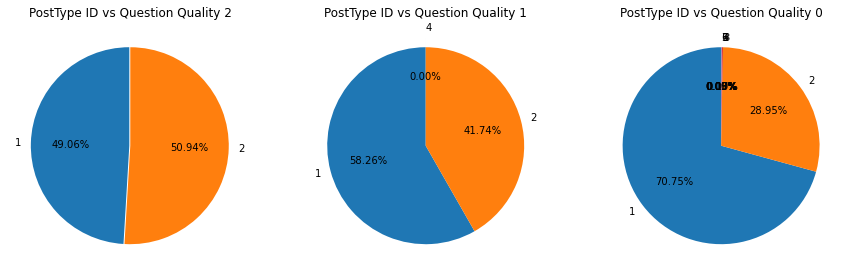

In [28]:
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

ax.pie(qual2['question_quality'], labels = qual2.index, autopct = '%0.2f%%', explode = [0.01,0], startangle = 90)
ax.set_title('PostType ID vs Question Quality 2')
ax1.pie(qual1['question_quality'], labels = qual1.index, autopct = '%0.2f%%', explode = [0,0,0.1], startangle = 90)
ax1.set_title('PostType ID vs Question Quality 1')
ax2.pie(qual0['question_quality'], labels = qual0.index, autopct = '%0.2f%%', startangle = 90)
ax2.set_title('PostType ID vs Question Quality 0')

plt.show()

In [29]:
df.head()

,posttypeid,score,viewcount,owneruserid,answercount,commentcount,favoritecount,question_quality
0,1,76,13803,7,5,5,27,2.0
1,1,29,2641,23,4,4,8,2.0
2,1,35,2412,40,3,5,13,2.0
3,2,22,50,20,1,3,1,2.0
4,2,48,50,13,1,0,1,2.0


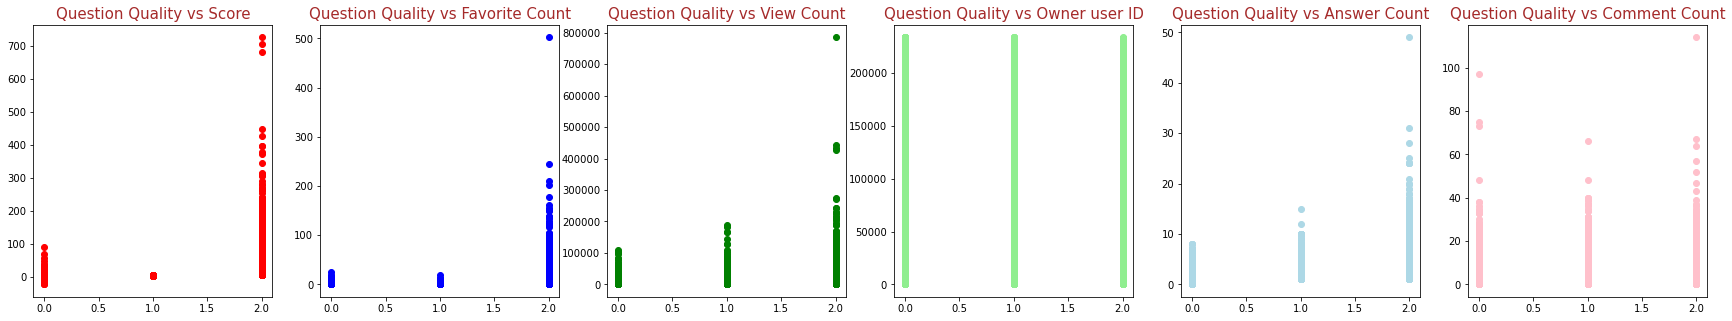

In [30]:
fig, (ax,ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows = 1, ncols = 6, figsize = (30,5))

ax.scatter(df['question_quality'], df['score'], color = 'r')
ax.set_title('Question Quality vs Score', color = 'brown', fontsize = 15)
ax1.scatter(df['question_quality'], df['favoritecount'], color = 'b')
ax1.set_title('Question Quality vs Favorite Count', color = 'brown', fontsize = 15)
ax2.scatter(df['question_quality'], df['viewcount'], color = 'g')
ax2.set_title('Question Quality vs View Count', color = 'brown', fontsize = 15)
ax3.scatter(df['question_quality'], df['owneruserid'], color = 'lightgreen')
ax3.set_title('Question Quality vs Owner user ID', color = 'brown', fontsize = 15)
ax4.scatter(df['question_quality'], df['answercount'], color = 'lightblue')
ax4.set_title('Question Quality vs Answer Count', color = 'brown', fontsize = 15)
ax5.scatter(df['question_quality'], df['commentcount'], color = 'pink')
ax5.set_title('Question Quality vs Comment Count', color = 'brown', fontsize = 15)

plt.show()

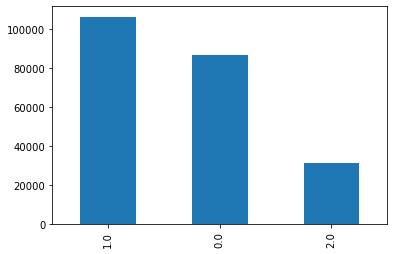

In [31]:
df['question_quality'].value_counts().plot(kind = 'bar')

plt.show()

In [32]:
x = df.iloc[ : , 0 : -1].values
y = df.iloc[ : , -1].values

### Dependent variable is varying from 0 to 2 but out Features are having different varying data, so using Standard Scalar i'm scaling the Feature values

In [33]:
scalar = StandardScaler()

In [34]:
x = scalar.fit_transform(x)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# Model Building

In [36]:
logistic = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 5)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_estimators = 5)

In [37]:
logistic.fit(x_train,y_train)

LogisticRegression()

In [38]:
logistic.score(x_test, y_test)

0.891597626095105

In [39]:
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [40]:
knn.score(x_test,y_test)

0.9770344037720694

In [41]:
tree.fit(x_train,y_train)

DecisionTreeClassifier()

In [42]:
tree.score(x_test,y_test)

1.0

In [43]:
forest.fit(x_train,y_train)

RandomForestClassifier(n_estimators=5)

In [44]:
forest.score(x_test,y_test)

1.0

# Validating the Model

In [45]:
models = [logistic,knn,tree,forest]
scores = []
for i in models:
    scores.append(np.average(cross_val_score(i, x, y, cv = 10)))
print(scores)

[0.8943197855502645, 0.954614186621199, 1.0, 0.9999375282875587]


### From Cross Validation Decision Tree is giving higher scores, so considering it as a model for this data

In [46]:
y_pred = tree.predict(x_test)

In [47]:
cm = confusion_matrix(y_test,y_pred)

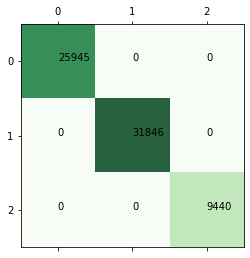

In [48]:
plt.matshow(cm, cmap = 'Greens', alpha = 0.85)

for i in range(3):
    for j in range(3):
        plt.text(x = j, y = i, s = cm[i,j])
        
plt.show()

In [49]:
acc_score = accuracy_score(y_test,y_pred)
print(acc_score * 100, '%')

100.0 %


### Hence, <br> from the above analysis and model selection, Decision Tree will work perfectly for this data as it's giving accuracy of 100%